In [1]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import joblib

# 1. 初始化模型和预处理步骤

In [2]:
# 基础目录设置
BASE_DIR = "/Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/label_model_data"

# 设置设备
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"使用设备: {device}")

# 初始化ResNet18
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights).to(device)
model = torch.nn.Sequential(*list(model.children())[:-1])  # 移除分类层
model.eval()

# 图像预处理
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

使用设备: mps


# 2. 特征提取函数

In [3]:
def extract_features_batch(image_paths, batch_size=32):
    """从图像中批量提取特征"""
    features_list = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = []
        for p in batch_paths:
            try:
                img = Image.open(p).convert("RGB")
                batch_images.append(preprocess(img))
            except Exception as e:
                print(f"处理图像 {p} 时出错: {e}")
                # 添加一个零张量作为替代
                batch_images.append(torch.zeros(3, 224, 224))
        
        batch_tensor = torch.stack(batch_images).to(device)
        with torch.no_grad():
            batch_features = model(batch_tensor)
            batch_features = batch_features.squeeze(-1).squeeze(-1)
        features_list.append(batch_features.cpu().numpy())
        print(f"已处理 {i+len(batch_paths)}/{len(image_paths)} 张图像")
    
    return np.vstack(features_list)



# 3. 数据加载和准备

In [4]:
def load_data(data_path, image_dir):
    """加载和准备数据"""
    df = pd.read_csv(data_path, sep='\t')
    
    # 展示数据集分布
    print(f"数据集大小: {len(df)}")
    print(f"shatterSeek_label_TorF分布:\n{df['shatterSeek_label_TorF'].value_counts()}")
    
    # 确保特征是数值型
    for col in ['cn_2', 'cn_3', 'cn_segments', 'shatterSeek_label']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # 填充缺失值
        df[col].fillna(df[col].median(), inplace=True)
    
    # 构建完整图像路径
    image_paths = [os.path.join(image_dir, img) for img in df['image_path']]
    
    # 检查图像是否存在
    valid_paths = []
    valid_indices = []
    for i, path in enumerate(image_paths):
        if os.path.exists(path):
            valid_paths.append(path)
            valid_indices.append(i)
        else:
            print(f"警告: 图像 {path} 不存在")
    
    # 筛选有效数据
    df_valid = df.iloc[valid_indices].reset_index(drop=True)
    
    # 分离连续特征和二元特征
    continuous_features = df_valid[['cn_2', 'cn_3', 'cn_segments']].values
    binary_features = df_valid[['shatterSeek_label']].values
    labels = df_valid['shatterSeek_label_TorF'].values
    
    return df_valid, valid_paths, continuous_features, binary_features, labels

# 加载训练数据
print("加载训练数据...")
train_df, train_image_paths, train_continuous, train_binary, train_labels = load_data(
    os.path.join(BASE_DIR, "train_data.tsv"),
    os.path.join(BASE_DIR, "train")
)

# 加载测试数据
print("加载测试数据...")
test_df, test_image_paths, test_continuous, test_binary, test_labels = load_data(
    os.path.join(BASE_DIR, "test_data.tsv"),
    os.path.join(BASE_DIR, "test")
)


加载训练数据...
数据集大小: 2948
shatterSeek_label_TorF分布:
shatterSeek_label_TorF
1    2763
0     185
Name: count, dtype: int64
加载测试数据...
数据集大小: 54
shatterSeek_label_TorF分布:
shatterSeek_label_TorF
1    30
0    24
Name: count, dtype: int64


# 4. 特征提取

In [5]:
# 提取训练图像特征
print("提取训练图像特征...")
train_image_features = extract_features_batch(train_image_paths)
print(f"训练图像特征形状: {train_image_features.shape}")

# 提取测试图像特征
print("提取测试图像特征...")
test_image_features = extract_features_batch(test_image_paths)
print(f"测试图像特征形状: {test_image_features.shape}")

提取训练图像特征...
已处理 32/2948 张图像
已处理 64/2948 张图像
已处理 96/2948 张图像
已处理 128/2948 张图像
已处理 160/2948 张图像
已处理 192/2948 张图像
已处理 224/2948 张图像
已处理 256/2948 张图像
已处理 288/2948 张图像
已处理 320/2948 张图像
已处理 352/2948 张图像
已处理 384/2948 张图像
已处理 416/2948 张图像
已处理 448/2948 张图像
已处理 480/2948 张图像
已处理 512/2948 张图像
已处理 544/2948 张图像
已处理 576/2948 张图像
已处理 608/2948 张图像
已处理 640/2948 张图像
已处理 672/2948 张图像
已处理 704/2948 张图像
已处理 736/2948 张图像
已处理 768/2948 张图像
已处理 800/2948 张图像
已处理 832/2948 张图像
已处理 864/2948 张图像
已处理 896/2948 张图像
已处理 928/2948 张图像
已处理 960/2948 张图像
已处理 992/2948 张图像
已处理 1024/2948 张图像
已处理 1056/2948 张图像
已处理 1088/2948 张图像
已处理 1120/2948 张图像
已处理 1152/2948 张图像
已处理 1184/2948 张图像
已处理 1216/2948 张图像
已处理 1248/2948 张图像
已处理 1280/2948 张图像
已处理 1312/2948 张图像
已处理 1344/2948 张图像
已处理 1376/2948 张图像
已处理 1408/2948 张图像
已处理 1440/2948 张图像
已处理 1472/2948 张图像
已处理 1504/2948 张图像
已处理 1536/2948 张图像
已处理 1568/2948 张图像
已处理 1600/2948 张图像
已处理 1632/2948 张图像
已处理 1664/2948 张图像
已处理 1696/2948 张图像
已处理 1728/2948 张图像
已处理 1760/2948 张图像
已处理 1792/2948 张图像
已处理 1824/2948 

# 5. 特征处理和可视化

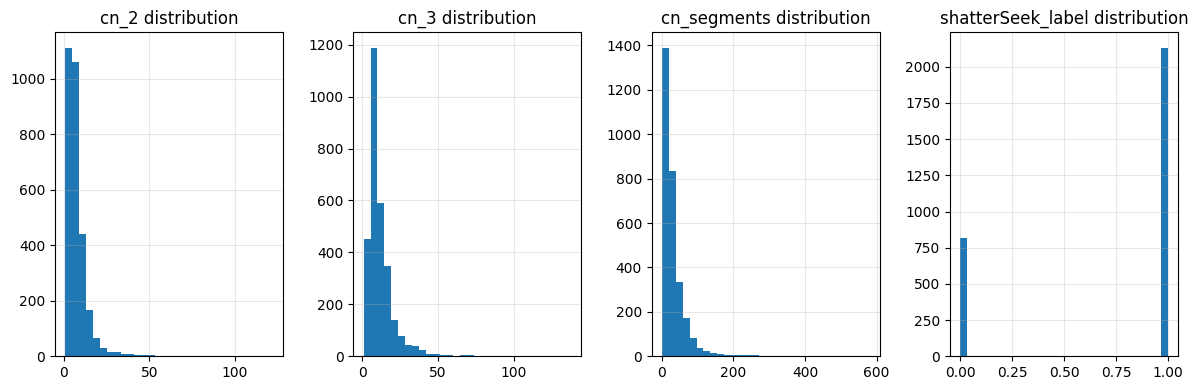

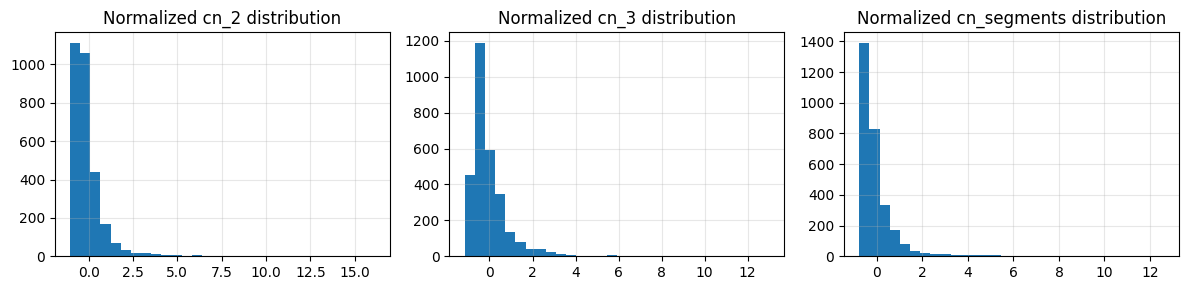

训练集合并特征形状: (2948, 516)
测试集合并特征形状: (54, 516)


In [6]:
# 可视化特征分布
def visualize_features(df, feature_names):
    """可视化特征分布"""
    plt.figure(figsize=(12, 4))
    for i, name in enumerate(feature_names):
        plt.subplot(1, len(feature_names), i+1)
        plt.hist(df[name], bins=30)
        plt.title(f'{name} distribution')
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_DIR, "feature_distribution.png"))
    plt.show()

# 显示原始特征分布
features_names = ['cn_2', 'cn_3', 'cn_segments', 'shatterSeek_label']
visualize_features(train_df, features_names)

# 标准化连续特征（cn_2, cn_3, cn_segments）
scaler = StandardScaler()  # Z-score normalization
train_continuous_scaled = scaler.fit_transform(train_continuous) # 只fit训练集
test_continuous_scaled = scaler.transform(test_continuous) # 用训练集的scaler去transform测试集

# 可视化标准化后的连续特征
plt.figure(figsize=(12, 3))
continuous_names = ['cn_2', 'cn_3', 'cn_segments']
for i, name in enumerate(continuous_names):
    plt.subplot(1, 3, i+1)
    plt.hist(train_continuous_scaled[:, i], bins=30)
    plt.title(f'Normalized {name} distribution')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "normalized_continuous_distribution.png"))
plt.show()

# 合并特征：图像特征 + 标准化连续特征 + 未标准化二元特征
train_combined_features = np.hstack((train_image_features, train_continuous_scaled, train_binary))
test_combined_features = np.hstack((test_image_features, test_continuous_scaled, test_binary))

print(f"训练集合并特征形状: {train_combined_features.shape}")
print(f"测试集合并特征形状: {test_combined_features.shape}")


# 6. 保存处理后的特征

In [7]:
# 创建目录
processed_dir = os.path.join(BASE_DIR, "processed_data")
os.makedirs(processed_dir, exist_ok=True)

# 保存特征和标签
np.save(os.path.join(processed_dir, 'train_combined_features.npy'), train_combined_features)
np.save(os.path.join(processed_dir, 'train_labels.npy'), train_labels)
np.save(os.path.join(processed_dir, 'test_combined_features.npy'), test_combined_features)
np.save(os.path.join(processed_dir, 'test_labels.npy'), test_labels)

# 保存数据处理器
joblib.dump(scaler, os.path.join(processed_dir, 'feature_scaler.pkl'))

# 保存特征维度信息 - 修改为包含三种类型特征的维度
np.save(os.path.join(processed_dir, 'feature_dimensions.npy'), 
       np.array([train_image_features.shape[1], train_continuous_scaled.shape[1], train_binary.shape[1]]))

print("所有数据处理完成并保存")


所有数据处理完成并保存


## 导入保存的特征向量

In [14]:
# 加载特征和标签
train_combined_features = np.load(os.path.join(processed_dir, 'train_combined_features.npy'))
train_labels = np.load(os.path.join(processed_dir, 'train_labels.npy'))
test_combined_features = np.load(os.path.join(processed_dir, 'test_combined_features.npy'))
test_labels = np.load(os.path.join(processed_dir, 'test_labels.npy'))

# 加载数据处理器
scaler = joblib.load(os.path.join(processed_dir, 'feature_scaler.pkl'))

# 加载特征维度信息
feature_dimensions = np.load(os.path.join(processed_dir, 'feature_dimensions.npy'))

print("所有数据已成功加载")

所有数据已成功加载


# 7. 交叉验证训练
* 之前模型：
    * 最佳参数: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}  
    * 交叉验证AUC: 0.9791  

最佳参数: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}  
交叉验证AUC: 0.9278

In [8]:
def train_with_cross_validation(X, y, n_splits=5, random_state=42):
    """使用交叉验证训练模型"""
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # 定义超参数网格
    param_grid = {
        'penalty': ['l1', 'l2', None],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga', 'lbfgs'],
        'class_weight': [None, 'balanced']
    }
        
    # 创建网格搜索
    grid_search = GridSearchCV(
        LogisticRegression(max_iter=10000), 
        param_grid, 
        cv=cv, 
        scoring='roc_auc',
        n_jobs=-1
    )
        
    # 训练模型
    print("开始网格搜索...")
    grid_search.fit(X, y)
    
    # 获取最佳模型
    best_model = grid_search.best_estimator_
    print(f"最佳参数: {grid_search.best_params_}")
    print(f"交叉验证AUC: {grid_search.best_score_:.4f}")
    
    return best_model, grid_search, cv

# 执行交叉验证训练
best_model, grid_search, cv = train_with_cross_validation(train_combined_features, train_labels)


开始网格搜索...


/Users/xurui/miniforge3/envs/d2l/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/xurui/miniforge3/envs/d2l/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/xurui/miniforge3/envs/d2l/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/xurui/miniforge3/envs/d2l/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/xurui/miniforge3/envs/d2l/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/xurui/miniforge3/envs/d

最佳参数: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
交叉验证AUC: 0.9278


# 8. ROC曲线绘制

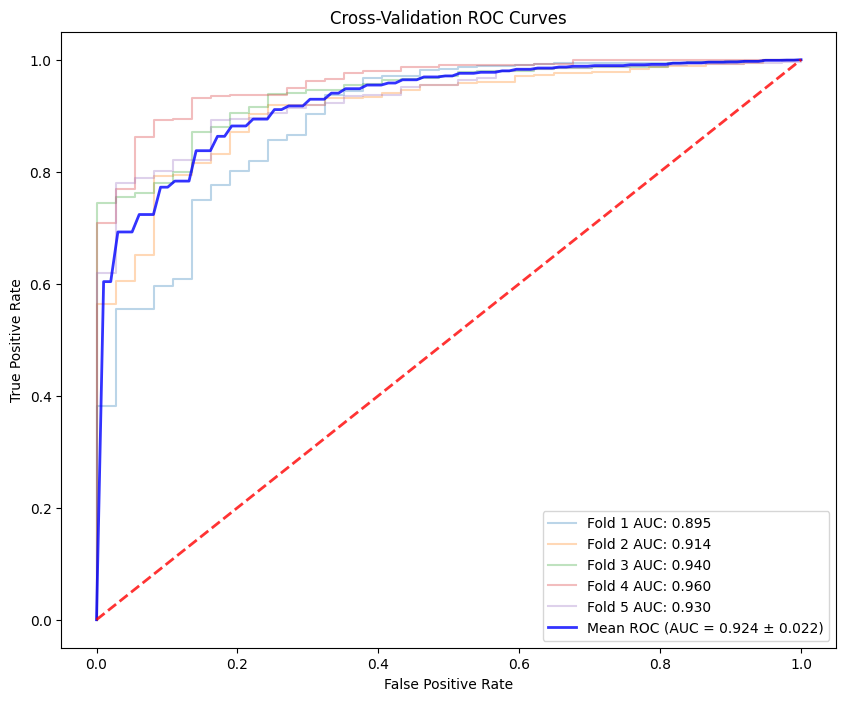

In [11]:
def plot_cv_roc_curves(X, y, cv, best_params, output_path=None):
    """绘制交叉验证ROC曲线"""
    plt.figure(figsize=(10, 8))
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_fold_train, X_fold_test = X[train_idx], X[test_idx]
        y_fold_train, y_fold_test = y[train_idx], y[test_idx]
        
        model = LogisticRegression(**best_params, max_iter=10000)
        model.fit(X_fold_train, y_fold_train)
        
        y_fold_prob = model.predict_proba(X_fold_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_fold_test, y_fold_prob)
        
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)
        plt.plot(fpr, tpr, alpha=0.3, label=f'Fold {i+1} AUC: {fold_auc:.3f}')
    
    # 平均ROC曲线
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', 
             label=f'Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})',
             lw=2, alpha=0.8)
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Cross-Validation ROC Curves')
    plt.legend(loc="lower right")
    
    if output_path:
        plt.savefig(output_path)
    
    plt.show()
    
    return mean_auc, std_auc

# 绘制交叉验证ROC曲线
cv_output_path = os.path.join(BASE_DIR, "cv_roc_curve.png")
mean_auc, std_auc = plot_cv_roc_curves(
    train_combined_features, 
    train_labels, 
    cv, 
    grid_search.best_params_,
    cv_output_path
)


# 9. 特征重要性分析

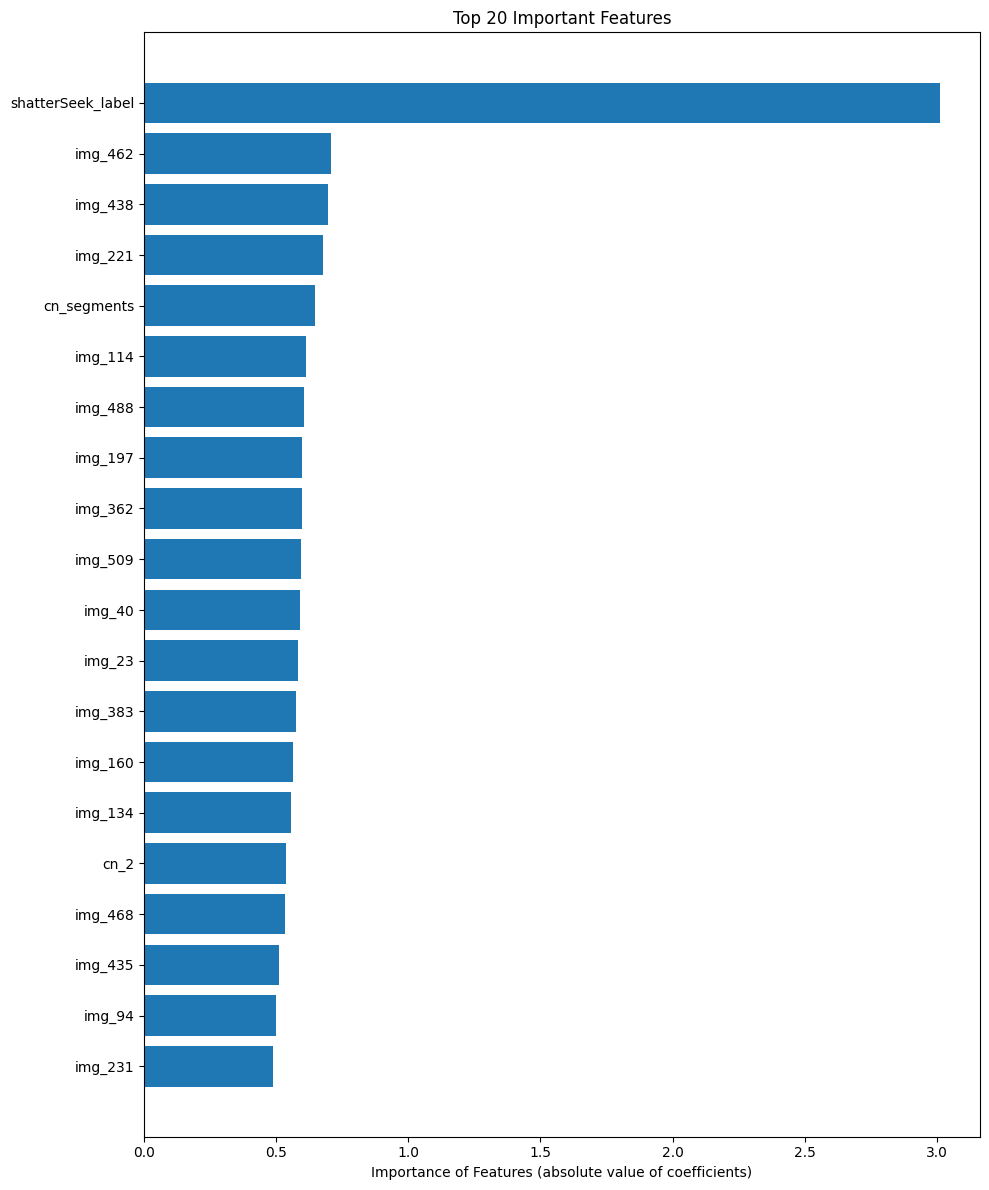

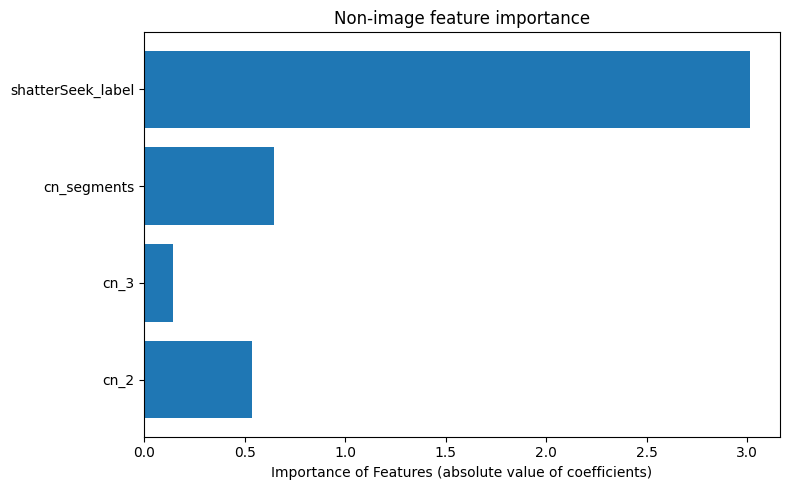

In [15]:
def analyze_feature_importance(model, feature_dimensions, output_path=None):
    """分析特征重要性"""
    if hasattr(model, 'coef_'):
        # 获取特征维度
        img_features_dim = int(feature_dimensions[0])
        continuous_features_dim = int(feature_dimensions[1])
        binary_features_dim = int(feature_dimensions[2])
        
        # 创建特征名称
        feature_names = [f'img_{i}' for i in range(img_features_dim)]
        feature_names.extend(['cn_2', 'cn_3', 'cn_segments'])  # 连续特征
        feature_names.extend(['shatterSeek_label'])  # 二元特征
        
        # 获取系数
        coefs = model.coef_[0]
        
        # 计算特征重要性
        importance = np.abs(coefs)
        
        # 找出最重要的特征（前20个）
        top_indices = np.argsort(importance)[-20:]
        
        plt.figure(figsize=(10, 12))
        plt.barh([feature_names[i] for i in top_indices], importance[top_indices])
        plt.xlabel('Importance of Features (absolute value of coefficients)')
        plt.title('Top 20 Important Features')
        plt.tight_layout()
        
        if output_path:
            plt.savefig(output_path)
        
        plt.show()
        
        # 单独查看非图像特征的重要性
        non_img_start = img_features_dim
        non_img_indices = np.arange(non_img_start, non_img_start + continuous_features_dim + binary_features_dim)
        non_img_names = ['cn_2', 'cn_3', 'cn_segments', 'shatterSeek_label']
        
        plt.figure(figsize=(8, 5))
        plt.barh(non_img_names, np.abs(coefs[non_img_indices]))
        plt.xlabel('Importance of Features (absolute value of coefficients)')
        plt.title('Non-image feature importance')
        plt.tight_layout()
        
        if output_path:
            plt.savefig(output_path.replace('.png', '_nonimg.png'))
        
        plt.show()

# 分析特征重要性
importance_output_path = os.path.join(BASE_DIR, "feature_importance.png")
analyze_feature_importance(best_model, feature_dimensions, importance_output_path)


# 10.  保存最佳模型

In [16]:
model_path = os.path.join(BASE_DIR, "best_model.pkl")
joblib.dump(best_model, model_path)
print(f"最佳模型已保存到 {model_path}")

最佳模型已保存到 /Volumes/T7-shield/CS-Bachelor-Thesis/CNN_model/label_model_data/best_model.pkl


# 11. 独立测试集评估

测试集准确率: 0.8148
分类报告:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77        24
           1       0.79      0.90      0.84        30

    accuracy                           0.81        54
   macro avg       0.82      0.80      0.81        54
weighted avg       0.82      0.81      0.81        54



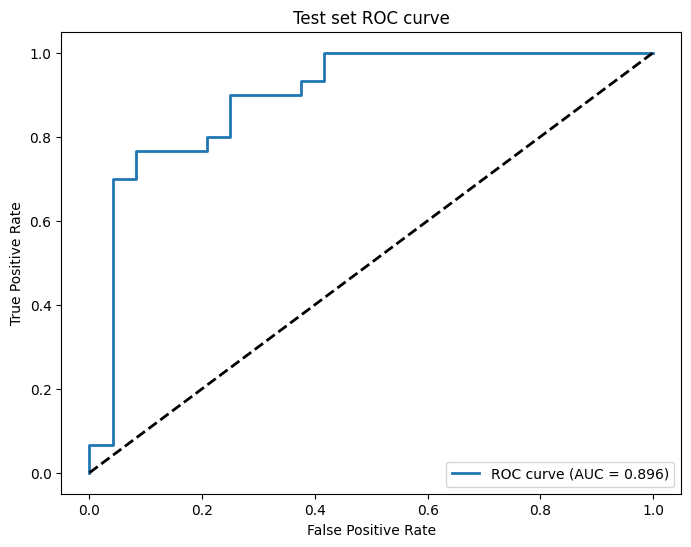

模型训练和评估完成!


In [17]:
def evaluate_on_test_set(model, X_test, y_test, output_path=None):
    """在独立测试集上评估模型"""
    # 预测
    test_pred = model.predict(X_test)
    test_prob = model.predict_proba(X_test)[:, 1]
    
    # 准确率
    test_accuracy = accuracy_score(y_test, test_pred)
    print(f"测试集准确率: {test_accuracy:.4f}")
    
    # 分类报告
    print("分类报告:")
    print(classification_report(y_test, test_pred))
    
    # ROC曲线和AUC
    fpr, tpr, _ = roc_curve(y_test, test_prob)
    test_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {test_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Test set ROC curve')
    plt.legend(loc="lower right")
    
    if output_path:
        plt.savefig(output_path)
    
    plt.show()
    
    return test_accuracy, test_auc

# 评估测试集
test_output_path = os.path.join(BASE_DIR, "test_roc_curve.png")
test_accuracy, test_auc = evaluate_on_test_set(best_model, test_combined_features, test_labels, test_output_path)

print("模型训练和评估完成!")
